# Task 1 (E2E and CMS): Photon/Electron Classification (TensorFlow/Keras version)
### Chenguang Guan

1. Details, discussion and notes are included in the Pytorch version. The TensorFlow/Keras version only includes the main results.

2. Pytorch notebook explored various methods: MLP, CNN(LeNet), Simplified ResNet, Pre-trained ResNet-18, Pre-traiend (and not pre-traiend) VGG 16, Pre-trained Vision Transformer (ViT). 

3. While This notebook (TensorFlow version) mainly dicussed LeNet-5 (CNN structure) and Simplified ResNet.

## I. Preparation

In [ ]:
!/opt/bin/nvidia-smi

Fri Mar 31 12:43:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    49W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
!cp --recursive "/content/gdrive/MyDrive/CMS_data" .

In [3]:
import h5py

import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


import random
import time

from sklearn import metrics

In [4]:
import matplotlib.pyplot as plt

## II. Dataset

In [5]:
shuffle_list = np.arange(0, 249000*2, 1) 
random.shuffle(shuffle_list)

In [6]:
f1 = h5py.File(r'/content/CMS_data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')
f2 = h5py.File(r'/content/CMS_data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')
total_X = np.concatenate( (f1["X"][:], f2["X"][:] ), axis=0 )
total_y = np.concatenate( (f1["y"][:], f2["y"][:] ), axis=0 )

In [7]:
total_X = total_X[shuffle_list]
total_y = total_y[shuffle_list].astype(int)

In [8]:
train_len = int( len(total_X) * 9/10 )

In [ ]:
# total_X = np.concatenate( (total_X, total_X[:,:,:,:1]), axis = 3)

## III. LeNet-5 (CNN)

In [ ]:
model_CNN = models.Sequential()
model_CNN.add(layers.Conv2D(filters=6, kernel_size = (5, 5), activation='relu', input_shape=(32, 32, 2)))
model_CNN.add(layers.MaxPooling2D((2, 2)))
model_CNN.add(layers.Conv2D(filters=16, kernel_size = (5, 5), activation='relu', input_shape=(14, 14, 6)) )
model_CNN.add(layers.MaxPooling2D((2, 2)))
model_CNN.add( layers.Flatten(input_shape=(5, 5, 16)) )
model_CNN.add( layers.Dense(120, activation="relu") )
model_CNN.add( layers.Dense(84, activation="relu") )
model_CNN.add( layers.Dense(2) )

In [ ]:
model_CNN.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model_CNN.fit(total_X[:train_len], total_y[:train_len], epochs=10 )

Epoch 1/10
14007/14007 [==============================] - 56s 3ms/step - loss: 0.6140 - accuracy: 0.6659
Epoch 2/10
14007/14007 [==============================] - 46s 3ms/step - loss: 0.5822 - accuracy: 0.7009
Epoch 3/10
14007/14007 [==============================] - 45s 3ms/step - loss: 0.5748 - accuracy: 0.7069
Epoch 4/10
14007/14007 [==============================] - 45s 3ms/step - loss: 0.5707 - accuracy: 0.7112
Epoch 5/10
14007/14007 [==============================] - 45s 3ms/step - loss: 0.5676 - accuracy: 0.7134
Epoch 6/10
14007/14007 [==============================] - 45s 3ms/step - loss: 0.5647 - accuracy: 0.7158
Epoch 7/10
14007/14007 [==============================] - 45s 3ms/step - loss: 0.5626 - accuracy: 0.7176
Epoch 8/10
14007/14007 [==============================] - 45s 3ms/step - loss: 0.5607 - accuracy: 0.7191
Epoch 9/10
14007/14007 [==============================] - 45s 3ms/step - loss: 0.5594 - accuracy: 0.7202
Epoch 10/10
14007/14007 [==============================

In [ ]:
test_loss, test_acc = model_CNN.evaluate(total_X[train_len:], total_y[train_len:], verbose=2)

1557/1557 - 3s - loss: 0.5570 - accuracy: 0.7223 - 3s/epoch - 2ms/step


In [ ]:
print('\nTest accuracy:', test_acc, '\nTest loss:', test_loss)


Test accuracy: 0.7223494052886963 
Test loss: 0.5569549798965454


In [ ]:
probability_model = tf.keras.Sequential([model_CNN, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(total_X[train_len:])

1557/1557 [==============================] - 2s 1ms/step


In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(total_y[train_len:], predictions[:, 1:])
AUC_score = metrics.roc_auc_score(total_y[train_len:], predictions[:, 1:])

In [ ]:
print("The ROC-AUC score of LeNet-5 is:", AUC_score)

The ROC-AUC score of Single Channel Simpified ResNet is: 0.7867998944809327


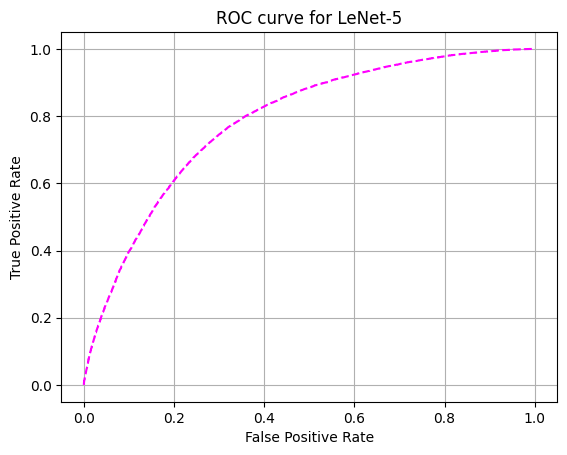

In [ ]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for LeNet-5")
plt.show()

## IV. Simplified ResNet (two blocks)

In [14]:
class ResBlock(tf.keras.Model):
  def __init__(self, channels_in):
    super(ResBlock, self).__init__()
    filters1, filters2 = 30, channels_in

    self.conv2a = layers.Conv2D(filters1, kernel_size = (5, 5), padding="same")
    self.bn2a = layers.BatchNormalization()

    self.conv2b = layers.Conv2D(filters2, kernel_size = (3, 3), padding='same')
    self.bn2b = layers.BatchNormalization()

  def call(self, input_tensor, training=False):
    x = self.conv2a(input_tensor)
    x = self.bn2a(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2b(x)
    x = self.bn2b(x, training=training)

    x += input_tensor
    return tf.nn.relu(x)

In [15]:
model_Simple_ResNet = models.Sequential()
model_Simple_ResNet.add( layers.Conv2D(filters=20, kernel_size = (5, 5), activation='relu', input_shape=(32, 32, 2)) )
model_Simple_ResNet.add( layers.MaxPooling2D((2, 2)) )
block1 = ResBlock(channels_in=20) 
model_Simple_ResNet.add( block1 )
model_Simple_ResNet.add( layers.Conv2D(filters=15, kernel_size = (3, 3), activation='relu', input_shape=(None, None, 20)) )
model_Simple_ResNet.add( layers.MaxPooling2D((2, 2)) )
block2 = ResBlock(channels_in=15) 
model_Simple_ResNet.add( block2 )
model_Simple_ResNet.add( layers.Flatten(input_shape=(6, 6, 15)) )
model_Simple_ResNet.add( layers.Dense(100, activation="relu") )
model_Simple_ResNet.add( layers.Dense(2) )

In [17]:
model_Simple_ResNet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model_Simple_ResNet.fit(total_X[:train_len], total_y[:train_len], epochs=10 )

Epoch 1/10
14007/14007 [==============================] - 84s 5ms/step - loss: 0.6133 - accuracy: 0.6670
Epoch 2/10
14007/14007 [==============================] - 72s 5ms/step - loss: 0.5758 - accuracy: 0.7069
Epoch 3/10
14007/14007 [==============================] - 72s 5ms/step - loss: 0.5674 - accuracy: 0.7138
Epoch 4/10
14007/14007 [==============================] - 72s 5ms/step - loss: 0.5622 - accuracy: 0.7170
Epoch 5/10
14007/14007 [==============================] - 72s 5ms/step - loss: 0.5587 - accuracy: 0.7199
Epoch 6/10
14007/14007 [==============================] - 73s 5ms/step - loss: 0.5556 - accuracy: 0.7216
Epoch 7/10
14007/14007 [==============================] - 72s 5ms/step - loss: 0.5532 - accuracy: 0.7247
Epoch 8/10
14007/14007 [==============================] - 72s 5ms/step - loss: 0.5511 - accuracy: 0.7257
Epoch 9/10
14007/14007 [==============================] - 72s 5ms/step - loss: 0.5497 - accuracy: 0.7271
Epoch 10/10
14007/14007 [==============================

In [19]:
test_loss, test_acc = model_Simple_ResNet.evaluate(total_X[train_len:], total_y[train_len:], verbose=2)
print('\nTest accuracy:', test_acc, '\nTest loss:', test_loss)

1557/1557 - 3s - loss: 0.5775 - accuracy: 0.7039 - 3s/epoch - 2ms/step

Test accuracy: 0.7038553953170776 
Test loss: 0.5774676203727722


In [20]:
probability_model = tf.keras.Sequential([model_Simple_ResNet, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(total_X[train_len:])

1557/1557 [==============================] - 3s 2ms/step


In [21]:
fpr, tpr, thresholds = metrics.roc_curve(total_y[train_len:], predictions[:, 1:])
AUC_score = metrics.roc_auc_score(total_y[train_len:], predictions[:, 1:])

In [22]:
print("The ROC-AUC score of Simplified ResNet is:", AUC_score)

The ROC-AUC score of Simplified ResNet is: 0.7816885715092157


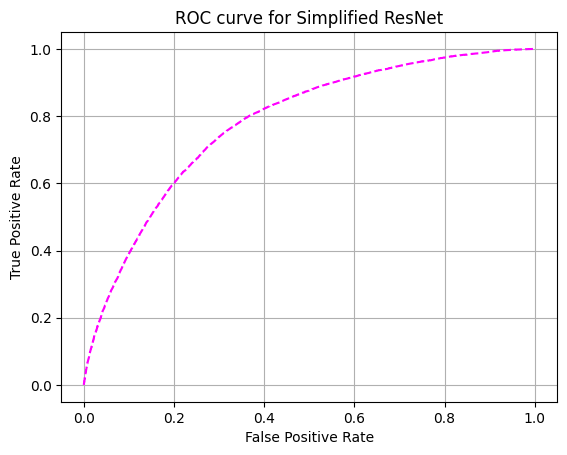

In [23]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Simplified ResNet")
plt.show()